In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from Autoencoders import ConformalAutoencoder

import optuna.visualization as vis
import optuna
import optunahub

from torchvision.datasets import MNIST
from torchvision import transforms

random_state = 42
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:1


In [2]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super(Encoder, self).__init__()
        #input dim = 1, 32, 32
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 8, 3, stride=1, padding=1),  # (8, 32, 32)
            nn.ELU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),  # (16, 16, 16)
            nn.ELU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (32, 8, 8)
            nn.ELU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (64, 4, 4)
            nn.ELU(True),
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),  # Flatten to (256,)
            nn.ELU(True),
            nn.Linear(256, 128),  # Flatten to (128,)
            nn.ELU(True),
            nn.Linear(128, latent_dim)  # Output latent dimension
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),  # Input latent dimension
            nn.ELU(True),
            nn.Linear(128, 256),  # Input latent dimension
            nn.ELU(True),
            nn.Linear(256, 64 * 4 * 4),  # Output size to reshape
            nn.ELU(True),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # (32, 8, 8)
            nn.ELU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (16, 16, 16)
            nn.ELU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),  # (8, 32, 32)
            nn.ELU(True),
            nn.ConvTranspose2d(8, out_channels, 3, stride=1, padding=1),  # (out_channels, 32, 32)
            nn.Sigmoid()  # For pixel values between 0 and 1
        )
    
    def forward(self, z):
        z = self.fc(z)
        z = torch.unflatten(z, 1, (64, 4, 4))  # Reshape to (64, 4, 4)
        z = self.deconv(z)
        return z

In [3]:
mnist = MNIST(root='data', train=True, download=True, transform=None)
data, labels = mnist.data, mnist.targets
data = data[labels == 3][:3000]
labels = labels[labels == 3]
data = torch.tensor(data, dtype=torch.float32).to(device)
data = transforms.Resize((32, 32))(data)  # Resize to 32x32
data = data / 255.0  # Normalize the images to [0, 1]
data = data.view(data.size(0), 1, 32, 32)  # Add channel dimension
mnist_val = MNIST(root='data', train=False, download=True, transform=None)
val_data, val_labels = mnist_val.data, mnist_val.targets
val_data = val_data[val_labels == 3][:1000]
val_labels = val_labels[val_labels == 3]
val_data = torch.tensor(val_data, dtype=torch.float32).to(device)
val_data = transforms.Resize((32, 32))(val_data)  # Resize to 32x32
val_data = val_data / 255.0  # Normalize the images to [0, 1]
val_data = val_data.view(val_data.size(0), 1, 32, 32)  # Add channel dimension

/tmp/ipykernel_1438133/315428273.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).to(device)
/tmp/ipykernel_1438133/315428273.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data = torch.tensor(val_data, dtype=torch.float32).to(device)


In [4]:
from metrics import evaluate_conformality, conformality_cosine_loss, conformality_cosine_orthounit_loss, conformality_trace_loss, conformality_trace2_loss, regularization

def objective(trial):
    lambda_conf = trial.suggest_float("lambda_conf", 0.1, 25.0, log=True)
    lambda_reg = trial.suggest_float("lambda_reg", 0.00001, 2.0, log=True)
    conf_loss = "cosine" #trial.suggest_categorical("conformality_loss", ["trace","trace2", "cosine"]) #["trace","trace2", "cosine", "cosine2"]
    lambda_aug = 0.1
    lambda_conf_schedule = None
    lambda_reg_schedule = None
    num_samples_conf = 1
    num_samples_reg = 1

    epochs = 1000
    batch_size = 256
    latent_dim = 24
    learning_rate = 0.001
    scheduler_kwargs={"step_size": 100, "gamma": 0.7}

    train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
    decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
    conformal_autoencoder = ConformalAutoencoder(encoder, decoder,
                                                 lambda_conf=lambda_conf, lambda_reg=lambda_reg, lambda_aug=lambda_aug,
                                                 lambda_conf_schedule=lambda_conf_schedule, lambda_reg_schedule=lambda_reg_schedule
                                                ).to(device)
    
    if conf_loss == "trace":
        conformal_autoencoder.conformality_loss = lambda func, z: conformality_trace_loss(func, z, num_samples=num_samples_conf)
    elif conf_loss == "trace2":
        conformal_autoencoder.conformality_loss = lambda func, z: conformality_trace2_loss(func, z, num_samples=num_samples_conf)
    elif conf_loss == "cosine":
        conformal_autoencoder.conformality_loss = conformality_cosine_loss
    elif conf_loss == "cosine2":
        conformal_autoencoder.conformality_loss = conformality_cosine_orthounit_loss
    else:
        conformal_autoencoder.conformality_loss = lambda func, z: 0.0

    conformal_autoencoder.regularization_loss = lambda func, z: regularization(func, z, num_samples=num_samples_reg) #lambda func, z: 0.0


    optimizer, scheduler = conformal_autoencoder.train_model(train_dataloader, val_dataloader, batch_size=batch_size,
                                                             epochs=epochs, learning_rate=learning_rate, log_every=epochs+1, val_every=epochs+1,
                                                             scheduler_kwargs=scheduler_kwargs)

    stats, _ = evaluate_conformality(conformal_autoencoder, val_data[:1000])

    return stats['reconstruction_error'], np.abs(stats["determinant_vs_estimate_meanerror"]) #np.abs(stats['log_determinant_vs_estimate_mean'])

In [5]:
n_trials = 150
study_name = "cosine_optimal_params_v2"
storage = "sqlite:///optuna_study.db"

# sampler = optuna.samplers.NSGAIISampler()
module = optunahub.load_module(package="samplers/auto_sampler")
sampler=module.AutoSampler()
# search_space = {
#     "lambda_conf": np.logspace(np.log10((0.01)), np.log10((100.0)), num=7),
#     "lambda_reg": np.logspace(np.log10((0.0001)), np.log10((10.0)), num=7),
#     "conformality_loss": ["trace", "trace2", "cosine"],
# }
# sampler = optuna.samplers.GridSampler(search_space)

study = optuna.create_study(directions=['minimize', 'minimize'], sampler=sampler, storage=storage, study_name=study_name, load_if_exists=True)
study.optimize(objective, n_trials=n_trials)

[I 2025-10-17 18:31:52,618] A new study created in RDB with name: cosine_optimal_params_v2
[I 2025-10-17 18:42:14,765] Trial 0 finished with values: [0.008663246408104897, 0.059813715517520905] and parameters: {'lambda_conf': 9.300979302082986, 'lambda_reg': 0.001369657031063334}.
[I 2025-10-17 18:51:54,080] Trial 1 finished with values: [0.0029344302602112293, 0.3546594977378845] and parameters: {'lambda_conf': 0.6779709715894343, 'lambda_reg': 0.05247035118154981}.
[I 2025-10-17 19:01:36,835] Trial 2 finished with values: [0.014791067689657211, 0.028300732374191284] and parameters: {'lambda_conf': 24.238503191951338, 'lambda_reg': 1.9405176952546825e-05}.
[I 2025-10-17 19:10:49,788] Trial 3 finished with values: [0.004218348301947117, 0.12515155971050262] and parameters: {'lambda_conf': 2.393444014478655, 'lambda_reg': 3.7788224680952904e-05}.
[I 2025-10-17 19:20:30,897] Trial 4 finished with values: [0.010810177773237228, 0.034275904297828674] and parameters: {'lambda_conf': 18.0169

In [ ]:
# optuna.delete_study("trace_vs_trace2_2", storage=storage)

/tmp/ipykernel_487966/4253244549.py:1: FutureWarning: delete_study() got {'study_name'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['study_name', 'storage'] in delete_study() have been deprecated since v3.0.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.0.0 for details.
  optuna.delete_study("trace_vs_trace2_2", storage=storage)


In [4]:
study = optuna.load_study(
    study_name='cosine_optimal_params',
    storage='sqlite:///optuna_study.db'
)

In [60]:
study2 = optuna.create_study(directions=['minimize', 'minimize'], sampler=sampler, storage=storage, study_name="cosine_best_trials", load_if_exists=True)

[I 2025-10-20 13:04:31,340] Using an existing study with name 'cosine_best_trials' instead of creating a new one.


In [61]:
study2.trials

[FrozenTrial(number=0, state=1, values=[0.008696752600371838, 0.051842547953128815], datetime_start=datetime.datetime(2025, 8, 7, 16, 24, 12, 840658), datetime_complete=datetime.datetime(2025, 8, 7, 16, 34, 4, 246084), params={'lambda_conf': 10.338131825190251, 'lambda_reg': 8.258311239363068e-05}, user_attrs={}, system_attrs={'NSGAIISampler:generation': 0, 'auto:sampler': 'NSGAIISampler'}, intermediate_values={}, distributions={'lambda_conf': FloatDistribution(high=25.0, log=True, low=0.1, step=None), 'lambda_reg': FloatDistribution(high=2.0, log=True, low=1e-05, step=None)}, trial_id=1395, value=None),
 FrozenTrial(number=1, state=1, values=[0.006999283097684383, 0.054756686091423035], datetime_start=datetime.datetime(2025, 8, 7, 18, 52, 6, 635233), datetime_complete=datetime.datetime(2025, 8, 7, 19, 1, 56, 606821), params={'lambda_conf': 7.957290218200709, 'lambda_reg': 0.14125414700919905}, user_attrs={}, system_attrs={'NSGAIISampler:generation': 0, 'auto:sampler': 'NSGAIISampler'}

In [49]:
study2.add_trials(study.best_trials)

/tmp/ipykernel_2826757/2962579406.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

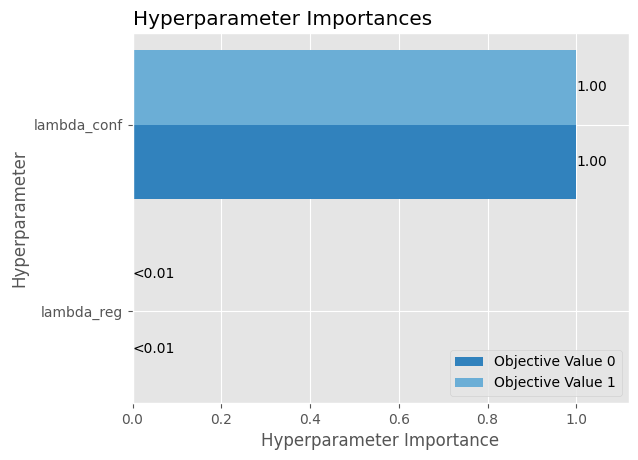

In [51]:
vis.matplotlib.plot_param_importances(study2)
# hps.axis("equal")

/tmp/ipykernel_290561/2657214259.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  pareto = vis.matplotlib.plot_pareto_front(study, target_names=["Reconstruction Error", "Determinant Estimate Error"])


(-0.056994274258613586, 1.0)

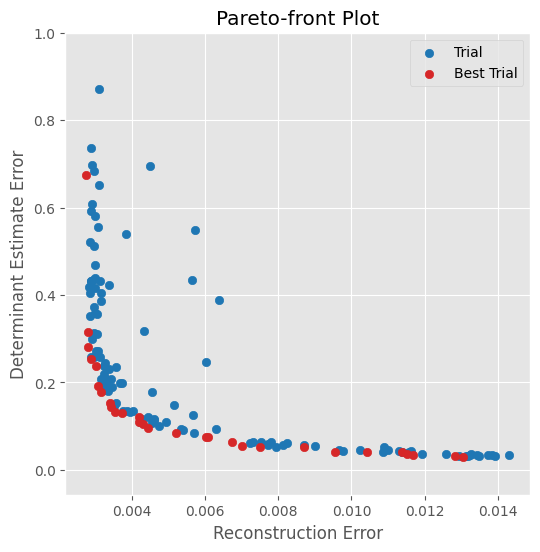

In [9]:
pareto = vis.matplotlib.plot_pareto_front(study, target_names=["Reconstruction Error", "Determinant Estimate Error"])
pareto.figure.set_size_inches(6, 6)
pareto.set_ylim(top=1.0)

# pareto.set_xscale("log")
# pareto.set_yscale("log")

# pareto.set_xscale("log")
# pareto.set_yscale("log")

/tmp/ipykernel_1438133/2479006062.py:2: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



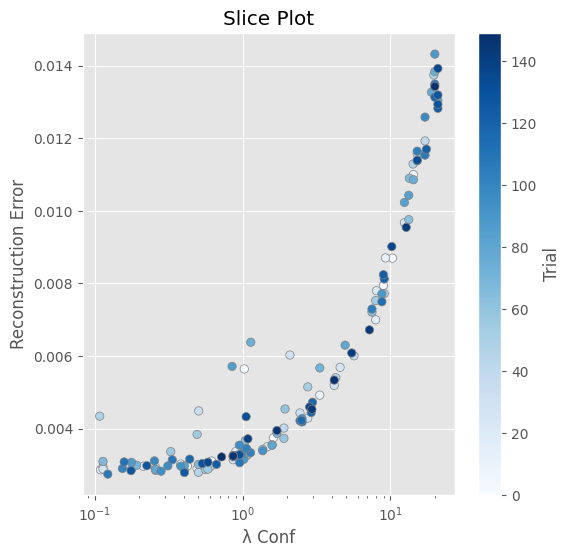

In [34]:
# plot objective 0 (first objective) across hyperparameters
slice0 = vis.matplotlib.plot_slice(study, params=["lambda_conf"], target=lambda t: t.values[0], target_name="Reconstruction Error")
slice0.figure.set_size_inches(6, 6)
slice0.set_xlabel("λ Conf")
plt.show()

/tmp/ipykernel_1438133/256512276.py:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



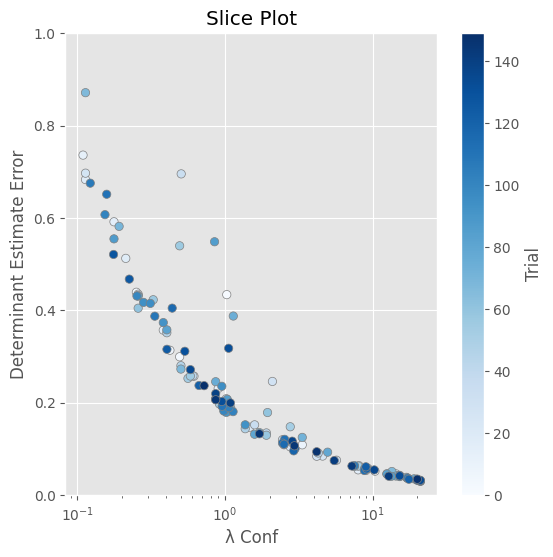

In [32]:
slice1 = vis.matplotlib.plot_slice(study, params=["lambda_conf"], target=lambda t: t.values[1], target_name="Determinant Estimate Error")
slice1.set_ylim(0.0, 1.0)
slice1.figure.set_size_inches(6, 6)
# set x label to Lambda Conf
slice1.set_xlabel("λ Conf")
plt.show()

In [18]:
fig = vis.plot_param_importances(study, evaluator=optuna.importance.MeanDecreaseImpurityImportanceEvaluator())  # plotly.graph_objs.Figure
labels = ["Determinant Estimate", "Reconstruction"]
colors = ['#1f77b4', '#ff7f0e']
for i, trace in enumerate(fig.data):
    trace.marker.color = colors[i % len(colors)]
    trace.name = labels[i]  # set legend label
    # set custom y-axis category labels with LaTeX
    fig.update_layout(
        yaxis=dict(
            categoryorder='array',
            categoryarray=["lambda_reg", "lambda_conf"],
            tickmode='array',
            tickvals=["lambda_reg", "lambda_conf"],
            ticktext=['λ_reg', "λ_conf"]  # LaTeX labels
        )
    )
fig.update_layout(width=650, height=450, legend=dict(y=0.01, x=0.6, traceorder='reversed'))
fig.show()

In [6]:
fig.data

(Bar({
     'cliponaxis': False,
     'hovertemplate': [lambda_reg (FloatDistribution):
                       0.014463848386535636<extra></extra>, lambda_conf
                       (FloatDistribution): 0.9855361516134644<extra></extra>],
     'marker': {'color': '#1f77b4'},
     'name': 'Determinant Estimate',
     'orientation': 'h',
     'text': [0.01, 0.99],
     'textposition': 'outside',
     'x': [0.014463848386535636, 0.9855361516134644],
     'y': [lambda_reg, lambda_conf]
 }),
 Bar({
     'cliponaxis': False,
     'hovertemplate': [lambda_reg (FloatDistribution):
                       0.051231404600740243<extra></extra>, lambda_conf
                       (FloatDistribution): 0.9487685953992598<extra></extra>],
     'marker': {'color': '#ff7f0e'},
     'name': 'Reconstruction',
     'orientation': 'h',
     'text': [0.05, 0.95],
     'textposition': 'outside',
     'x': [0.051231404600740243, 0.9487685953992598],
     'y': [lambda_reg, lambda_conf]
 }))

In [20]:
study3 = optuna.load_study(
    study_name='trace_optimal_params',
    storage='sqlite:///optuna_study.db'
)

In [91]:
study2 = optuna.create_study(directions=['minimize', 'minimize'], sampler=sampler, storage=storage, study_name="trace_best_trials", load_if_exists=True)

[I 2025-10-20 13:45:49,838] Using an existing study with name 'trace_best_trials' instead of creating a new one.


In [21]:
# Option A: set order by passing params in desired order
fig = vis.plot_param_importances(study3, evaluator=optuna.importance.MeanDecreaseImpurityImportanceEvaluator())  # plotly.graph_objs.Figure

# Option B (alternative): enforce a specific y-axis/category order after creating the figure
# If you prefer the other order, swap the list below.
fig.update_layout(yaxis=dict(categoryorder='array', categoryarray=["lambda_reg", "lambda_conf"]))
labels = ["Determinant Estimate", "Reconstruction"]
colors = ['#1f77b4', '#ff7f0e']
for i, trace in enumerate(fig.data):
    trace.marker.color = colors[i % len(colors)]
    trace.name = labels[i]  # set legend label


# set custom y-axis category labels with LaTeX
fig.update_layout(
    yaxis=dict(
        categoryorder='array',
        categoryarray=["lambda_reg", "lambda_conf"],
        tickmode='array',
        tickvals=["lambda_reg", "lambda_conf"],
        ticktext=['λ_reg', "λ_conf"]  # LaTeX labels
    )
)

# set pixel dimensions and legend
fig.update_layout(width=650, height=450, legend=dict(y=0.99, x=0.6, traceorder='reversed'))
fig.show()

In [23]:
study2 = optuna.load_study(
    study_name='iso_optimal_params',
    storage='sqlite:///optuna_study.db'
)

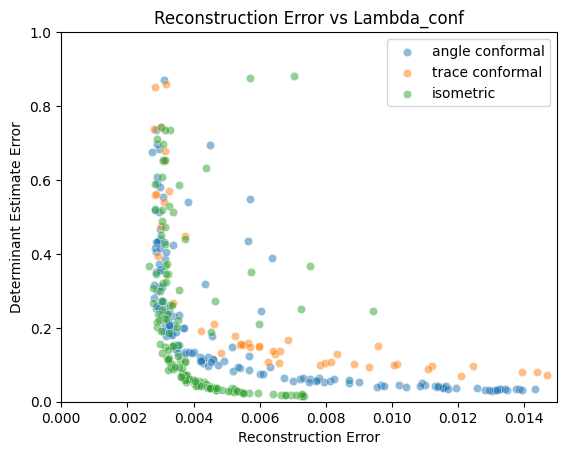

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert trials to DataFrame
df = study.trials_dataframe()
df2 = study2.trials_dataframe()
df3 = study3.trials_dataframe()

# Now plot with filtered data
sns.scatterplot(data=df, x='values_0', y='values_1', label="angle conformal", alpha=0.5)
sns.scatterplot(data=df3, x='values_0', y='values_1', label="trace conformal", alpha=0.5)
sns.scatterplot(data=df2, x='values_0', y='values_1', label="isometric", alpha=0.5)
plt.title("Reconstruction Error vs Lambda_conf")
# plt.xscale('log')
plt.ylim(0, 1.0)
plt.xlim(0, 0.015)
plt.xlabel("Reconstruction Error")
plt.ylabel("Determinant Estimate Error")
plt.show()

In [98]:
fig.data

(Bar({
     'cliponaxis': False,
     'hovertemplate': [lambda_conf (FloatDistribution):
                       0.3660945832016772<extra></extra>, lambda_reg
                       (FloatDistribution): 0.6339054167983228<extra></extra>],
     'marker': {'color': '#1f77b4'},
     'name': 'Determinant Estimate',
     'orientation': 'h',
     'text': [0.37, 0.63],
     'textposition': 'outside',
     'x': [0.3660945832016772, 0.6339054167983228],
     'y': [lambda_conf, lambda_reg]
 }),
 Bar({
     'cliponaxis': False,
     'hovertemplate': [lambda_conf (FloatDistribution):
                       0.018151335991300182<extra></extra>, lambda_reg
                       (FloatDistribution): 0.9818486640086999<extra></extra>],
     'marker': {'color': '#ff7f0e'},
     'name': 'Reconstruction',
     'orientation': 'h',
     'text': [0.02, 0.98],
     'textposition': 'outside',
     'x': [0.018151335991300182, 0.9818486640086999],
     'y': [lambda_conf, lambda_reg]
 }))

In [36]:
# 3d plot of objective0 as a function of lambda_conf and lambda_reg
vis.plot_contour(study, params=["lambda_conf", "lambda_reg"], target=lambda t: t.values[0])

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/optuna/visualization/_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [31]:
# 3d plot of objective0 as a function of lambda_conf and lambda_reg
vis.plot_contour(study, params=["lambda_conf", "lambda_reg"], target=lambda t: t.values[1])

In [42]:
# Filter study trials for specific parameter value
filtered_trials = [trial for trial in study.trials 
                  if trial.params.get('conformality_loss') == 'trace2']

# Create a new study with filtered trials
filtered_study = optuna.create_study(directions=['minimize', 'minimize'])
for trial in filtered_trials:
    filtered_study.add_trial(trial)

# Plot the filtered study
vis.plot_contour(filtered_study, params=["lambda_conf", "lambda_reg"], target=lambda t: t.values[1])

[I 2025-08-06 18:12:37,859] A new study created in memory with name: no-name-cb65c66b-6a30-4b83-b936-16c49bec19fd


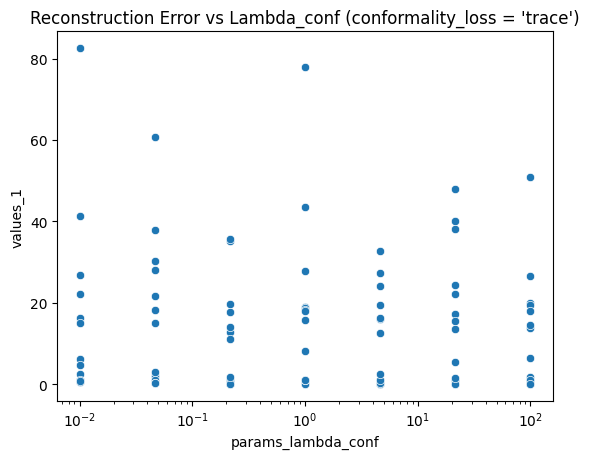

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert trials to DataFrame
df = study.trials_dataframe()

# Filter by specific parameter value
df_filtered = df[df['params_conformality_loss'] == 'trace']  # Only 'trace' trials
# Or filter for multiple values
df_filtered = df[df['params_conformality_loss'].isin(['trace', 'trace2'])]

# Now plot with filtered data
sns.scatterplot(data=df_filtered, x='params_lambda_conf', y='values_1')
plt.title("Reconstruction Error vs Lambda_conf (conformality_loss = 'trace')")
plt.xscale('log')
plt.show()

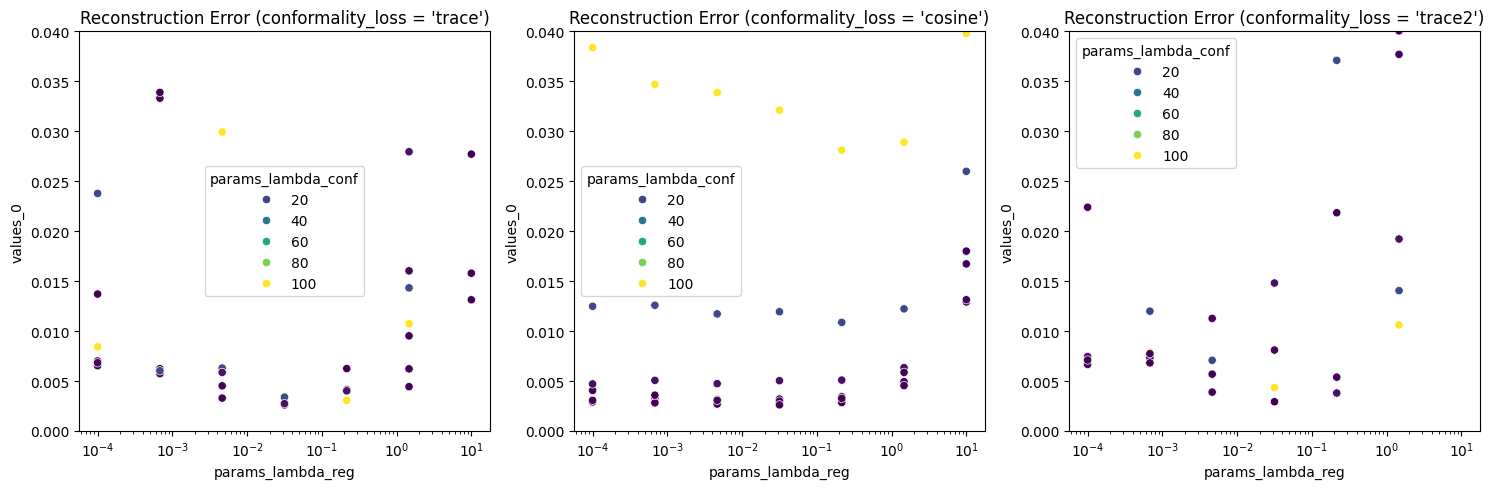

In [56]:
# Get unique values for the categorical parameter
conf_loss_types = df['params_conformality_loss'].unique()

fig, axes = plt.subplots(1, len(conf_loss_types), figsize=(15, 5))

for i, loss_type in enumerate(conf_loss_types):
    df_subset = df[df['params_conformality_loss'] == loss_type]
    
    sns.scatterplot(data=df_subset, x='params_lambda_reg', y='values_0', ax=axes[i], hue='params_lambda_conf', palette='viridis')
    axes[i].set_title(f"Reconstruction Error (conformality_loss = '{loss_type}')")
    axes[i].set_xscale('log')
    axes[i].set_ylim(0, 0.04)

plt.tight_layout()
plt.show()

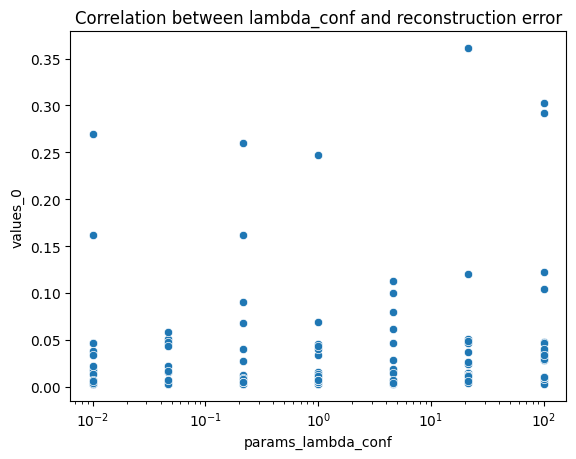

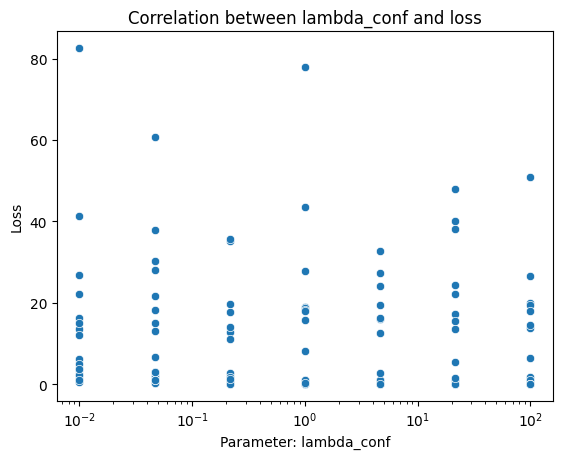

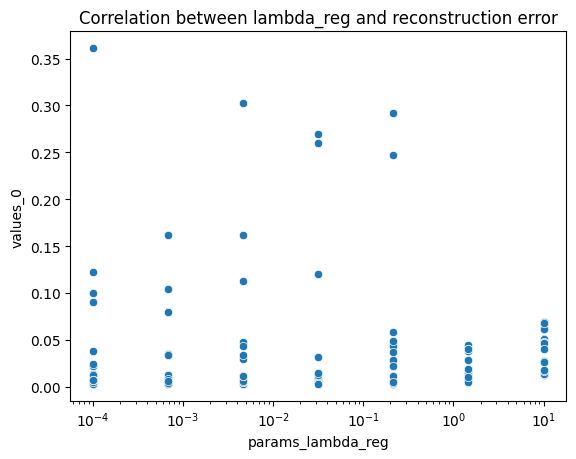

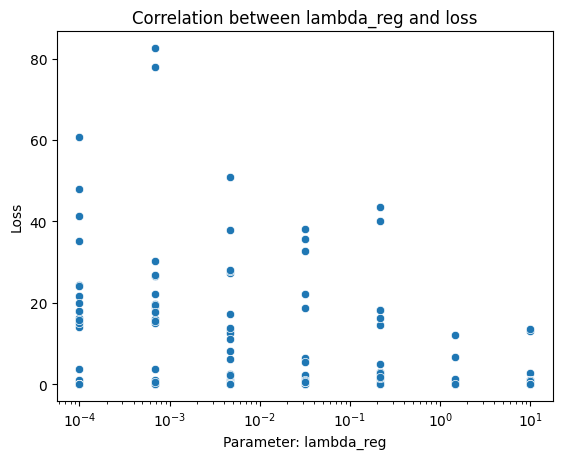

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert trials to DataFrame
df = study.trials_dataframe()

# Optional: filter only completed trials
df = df[df['state'] == 'COMPLETE']

# Choose a parameter
param1 = 'lambda_conf'  # or 'lambda_reg'
param2 = 'lambda_reg'

# Plot param vs loss
sns.scatterplot(data=df, x=f'params_{param1}', y='values_0')  # Assuming first value is reconstruction error
plt.title(f"Correlation between {param1} and reconstruction error")
# plt.ylim(0, 0.03)
plt.xscale('log')
plt.show()
sns.scatterplot(data=df, x=f'params_{param1}', y='values_1')  # Assuming 'value' is the loss
plt.xlabel(f'Parameter: {param1}')
plt.ylabel('Loss')
plt.xscale('log')  # Use logarithmic scale for better visibility
# plt.ylim(-1, 0)  # Adjust y-axis limit if necessary
plt.title(f"Correlation between {param1} and loss")
plt.show()
sns.scatterplot(data=df, x=f'params_{param2}', y='values_0')  # Assuming 'value' is the loss
plt.title(f"Correlation between {param2} and reconstruction error")
plt.xscale('log')
plt.show()
sns.scatterplot(data=df, x=f'params_{param2}', y='values_1')  # Assuming 'value' is the loss
plt.xlabel(f'Parameter: {param2}')
plt.ylabel('Loss')
# plt.ylim(-1, 0)  # Adjust y-axis limit if necessary
plt.title(f"Correlation between {param2} and loss")
plt.xscale('log')
plt.show()

In [ ]:
conformality_loss cosine
lambda_conf 0.1 - 25
lambda_ref 0.00001 - 2

In [59]:
vis.plot_pareto_front(study, include_dominated_trials=True)

In [61]:
vis.plot_pareto_front(study, include_dominated_trials=False)

In [24]:
import optuna.visualization as vis
vis.plot_contour(study, params=[param1, param2], target=lambda t: t.values[0])  # Assuming first value is reconstruction error

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/optuna/visualization/_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [13]:
print(study.trials_dataframe())

   number  values_0   values_1             datetime_start  \
0       0  0.131074  -0.195635 2025-07-28 17:43:49.210484   
1       1  0.077975  -0.437632 2025-07-28 17:43:55.598358   
2       2  0.118359  -0.008398 2025-07-28 17:44:01.260308   
3       3  0.067868  -0.062619 2025-07-28 17:44:06.906381   
4       4  0.132944  -0.123222 2025-07-28 17:44:12.574133   
5       5  0.032433  -0.916306 2025-07-28 17:44:18.240920   
6       6  0.149123  -0.382525 2025-07-28 17:44:23.903965   
7       7  0.121743  -0.962378 2025-07-28 17:44:29.568981   
8       8  0.054965 -10.185285 2025-07-28 17:44:35.251230   
9       9  0.103213  -0.011462 2025-07-28 17:44:40.906889   

           datetime_complete               duration  params_lambda_conf  \
0 2025-07-28 17:43:55.597779 0 days 00:00:06.387295            3.450764   
1 2025-07-28 17:44:01.259687 0 days 00:00:05.661329            4.271127   
2 2025-07-28 17:44:06.905917 0 days 00:00:05.645609            6.949206   
3 2025-07-28 17:44:12.573647